In [1]:
import pandas as pd
import numpy as np
import math
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, ShuffleSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.exceptions import ConvergenceWarning
from tqdm import tqdm, tqdm_notebook

# Preprocessing

### Import Dataset

In [2]:
df = pd.read_csv(
    "../Datasets/Raw_Data/GSE221521_gene_expression.csv", index_col=1)
df.head()

,gene_id,description,gene_type,locus,RNA1_FPKM,RNA102_FPKM,RNA104_FPKM,RNA108_FPKM,RNA109_FPKM,RNA110_FPKM,...,R_JS032_count,R_JS033_count,R_JS034_count,R_JS035_count,R_JS036_count,R_JS037_count,R_JS038_count,R_JS039_count,R_JS040_count,R_JS041_count
gene_name,,,,,,,,,,,,,,,,,,,,,
AC073488.4,ENSG00000282222,"chromodomain protein, Y chromosome-like (CDYL)...",processed_pseudogene,X:9410789-9411545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0
AC119427.1,ENSG00000282221,"novel transcript, antisense to LAD1",lncRNA,1:201399633-201401190,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
MIR543,ENSG00000212040,microRNA 543 [Source:HGNC Symbol;Acc:HGNC:33664],miRNA,14:101031987-101032064,0.000000,0.000000,0.000000,0.000000,0.000000,0.962816,...,0,0,0,0,0,0,0,0,0,0
MADD,ENSG00000110514,MAP kinase activating death domain [Source:HGN...,protein_coding,11:47269161-47330031,6.345943,8.482109,10.209322,7.143557,5.671481,7.776351,...,1187,1254,1767,1184,2418,1294,1254,1461,1323,1795
AL356737.2,ENSG00000287159,"novel transcript, antisense to GPC5",lncRNA,13:92610646-92677725,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


### Check Gene Types

In [3]:
df['gene_type'].value_counts()

protein_coding                        19973
lncRNA                                16889
processed_pseudogene                  10162
unprocessed_pseudogene                 2612
misc_RNA                               2220
snRNA                                  1910
miRNA                                  1879
TEC                                    1057
snoRNA                                  943
transcribed_unprocessed_pseudogene      938
transcribed_processed_pseudogene        500
rRNA_pseudogene                         496
IG_V_pseudogene                         187
IG_V_gene                               145
transcribed_unitary_pseudogene          138
TR_V_gene                               106
unitary_pseudogene                       98
TR_J_gene                                79
rRNA                                     53
scaRNA                                   49
polymorphic_pseudogene                   48
IG_D_gene                                37
TR_V_pseudogene                 

### Transform the Dataset

In [4]:
df = df[df['gene_type'] == 'IG_V_gene']
df = df.drop(['gene_type', 'description', 'gene_id', 'locus'], axis=1)
df = df.iloc[:, :193]
df = df.T
df.to_csv('../Datasets/Dataset18/data0.csv')

### Combine with Diagnosis

In [5]:
df = pd.read_csv('../Datasets/Dataset18/data0.csv', index_col=0)
diagnosis = pd.read_csv("../Datasets/Dataset05/Diagnosis.csv", index_col=0)
df['Diagnosis'] = diagnosis['Diagnosis']
df.to_csv('../Datasets/Dataset18/data1.csv')

df.head()

,IGHV3-21,IGHV1-18,IGKV6D-21,IGHV1-2,IGHV1-3,IGHV3-7,IGKV1-16,IGKV1-12,IGKV1D-42,IGLV4-60,...,IGHV1-46,IGKV1D-8,IGKV1-27,IGLV3-1,IGKV1D-33,IGKV1D-43,IGHV2-5,IGHV1OR15-1,IGHV6-1,Diagnosis
RNA1_FPKM,12.562776,6.393937,0.971177,2.095600,5.631351,10.530532,1.050824,1.596830,0.0,3.730715,...,0.727716,0.000000,0.831856,6.187715,1.351767,0.298655,8.406376,11.027168,3.637116,1
RNA102_FPKM,4.206247,5.146580,2.395433,4.879484,2.861868,15.247667,0.598039,1.325484,0.0,1.040985,...,0.230085,0.282221,0.591777,3.408283,0.986389,0.000000,9.171076,11.314836,1.452760,2
RNA104_FPKM,12.739570,13.180418,3.076819,7.455887,3.560773,9.468626,1.958398,0.929993,0.0,0.613399,...,0.452052,0.000000,2.131722,7.439944,0.968946,0.417388,7.833592,9.227172,8.740551,1
RNA108_FPKM,6.919122,4.510799,0.196544,3.471026,2.442900,2.431005,3.616283,1.818364,0.0,0.000000,...,0.368300,0.000000,1.894526,8.485508,0.736727,0.000000,5.105531,8.200668,5.231631,1
RNA109_FPKM,2.975320,3.315572,0.195591,1.342295,3.441480,3.347212,0.634683,0.000000,0.0,0.883500,...,0.488285,0.299463,0.837243,2.812750,1.046659,0.000000,3.173204,2.944696,1.541527,0


### Remove Patients who hasn't Diabetic

In [6]:
df = pd.read_csv('../Datasets/Dataset18/data1.csv', index_col=0)
df = df[df['Diagnosis'] != 0]
df['Diagnosis'] = df['Diagnosis'] - 1
df.to_csv("../Datasets/Dataset18/data2.csv")
df.head()

,IGHV3-21,IGHV1-18,IGKV6D-21,IGHV1-2,IGHV1-3,IGHV3-7,IGKV1-16,IGKV1-12,IGKV1D-42,IGLV4-60,...,IGHV1-46,IGKV1D-8,IGKV1-27,IGLV3-1,IGKV1D-33,IGKV1D-43,IGHV2-5,IGHV1OR15-1,IGHV6-1,Diagnosis
RNA1_FPKM,12.562776,6.393937,0.971177,2.095600,5.631351,10.530532,1.050824,1.596830,0.0,3.730715,...,0.727716,0.000000,0.831856,6.187715,1.351767,0.298655,8.406376,11.027168,3.637116,0
RNA102_FPKM,4.206247,5.146580,2.395433,4.879484,2.861868,15.247667,0.598039,1.325484,0.0,1.040985,...,0.230085,0.282221,0.591777,3.408283,0.986389,0.000000,9.171076,11.314836,1.452760,1
RNA104_FPKM,12.739570,13.180418,3.076819,7.455887,3.560773,9.468626,1.958398,0.929993,0.0,0.613399,...,0.452052,0.000000,2.131722,7.439944,0.968946,0.417388,7.833592,9.227172,8.740551,0
RNA108_FPKM,6.919122,4.510799,0.196544,3.471026,2.442900,2.431005,3.616283,1.818364,0.0,0.000000,...,0.368300,0.000000,1.894526,8.485508,0.736727,0.000000,5.105531,8.200668,5.231631,0
RNA110_FPKM,3.668450,8.793983,0.183618,0.900639,2.472152,6.114030,0.000000,0.943634,0.0,0.207458,...,0.802800,0.000000,0.393192,4.907035,1.179843,0.000000,0.596209,21.704816,1.809959,0


### Analyze the Dataset

In [7]:
df = pd.read_csv("../Datasets/Dataset18/data2.csv", index_col=0)
df.describe()

,IGHV3-21,IGHV1-18,IGKV6D-21,IGHV1-2,IGHV1-3,IGHV3-7,IGKV1-16,IGKV1-12,IGKV1D-42,IGLV4-60,...,IGHV1-46,IGKV1D-8,IGKV1-27,IGLV3-1,IGKV1D-33,IGKV1D-43,IGHV2-5,IGHV1OR15-1,IGHV6-1,Diagnosis
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.0,143.000000,...,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,10.652882,11.883033,0.831816,3.965968,5.963129,10.883995,1.410482,1.126580,0.0,1.367732,...,0.642387,0.068481,1.331612,7.616474,2.338695,0.192147,6.990041,12.568805,4.099954,0.468531
std,10.083030,42.111127,0.956883,5.130388,5.919090,18.246231,1.963555,1.826209,0.0,2.021445,...,0.668992,0.193652,1.053550,7.711197,3.073666,0.238157,13.933002,8.362385,3.981643,0.500763
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.395955,0.000000,0.000000
25%,5.075144,3.677376,0.184746,0.884370,2.678917,4.428677,0.599086,0.439250,0.0,0.346283,...,0.249404,0.000000,0.629647,3.349480,1.042342,0.000000,2.258194,7.266553,1.908479,0.000000
50%,8.366402,7.231413,0.605255,2.686125,4.047903,7.233559,1.050824,0.816250,0.0,0.719152,...,0.488294,0.000000,1.122947,5.624390,1.639889,0.000000,4.361633,10.877553,3.014633,0.000000
75%,13.278816,11.240801,1.066387,5.165577,8.075967,11.175682,1.583478,1.292487,0.0,1.781314,...,0.784374,0.000000,1.871988,9.159787,2.727791,0.339939,7.176001,16.079864,5.152760,1.000000
max,75.197266,505.753399,5.465628,36.815372,43.440430,200.825161,15.737202,20.177584,0.0,19.265639,...,4.995068,1.496192,5.195905,63.791084,33.005250,0.898805,150.856145,55.661091,28.962320,1.000000


In [8]:
df.dtypes

IGHV3-21       float64
IGHV1-18       float64
IGKV6D-21      float64
IGHV1-2        float64
IGHV1-3        float64
                ...   
IGKV1D-43      float64
IGHV2-5        float64
IGHV1OR15-1    float64
IGHV6-1        float64
Diagnosis        int64
Length: 146, dtype: object

In [10]:
df.isnull().sum()

IGHV3-21       0
IGHV1-18       0
IGKV6D-21      0
IGHV1-2        0
IGHV1-3        0
              ..
IGKV1D-43      0
IGHV2-5        0
IGHV1OR15-1    0
IGHV6-1        0
Diagnosis      0
Length: 146, dtype: int64

# Feature Selection

### Select best Feature Selection Algorithm

In [11]:
df = pd.read_csv("../Datasets/Dataset18/data2.csv", index_col=0)

features = df.drop('Diagnosis', axis=1)
target = df['Diagnosis']

result_df = pd.DataFrame(
    columns=['Feature Selection Algorithm', 'Feature Count', 'Cross Validation Score'])

feature_counts = [25, 50, 100, 150, 200]

feature_selection_algorithms = [
    ('Information Gain (Mutual info)', mutual_info_classif),
    ('Correlation Coefficient', f_classif),
    ('Chi-Square', chi2),
    ('Feature Importance', RandomForestClassifier().fit(
        features, target).feature_importances_)
]

cv = KFold(n_splits=5, shuffle=True, random_state=42)

for algo_name, algo_func in feature_selection_algorithms:
    for count in feature_counts:
        if algo_name == 'Feature Importance':
            selected_features = features.columns[algo_func.argsort(
            )[-count:][::-1]]
        else:
            selected_features = features.columns[algo_func(
                features, target)[0].argsort()[-count:][::-1]]

        clf = SVC(kernel='linear')
        cv_scores = cross_val_score(
            clf, features[selected_features], target, cv=cv)

        result_df = pd.concat([result_df, pd.DataFrame({
            'Feature Selection Algorithm': [algo_name],
            'Feature Count': [count],
            'Cross Validation Score': [f'{cv_scores.mean():.2f}+/-{cv_scores.std():.2f}']
        })], ignore_index=True)

print(result_df)

c:\Users\ACER\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  8  50  64  73  80  91 113 117 119] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  8  50  64  73  80  91 113 117 119] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  8  50  64  73  80  91 113 117 119] ar

       Feature Selection Algorithm Feature Count Cross Validation Score
0   Information Gain (Mutual info)            25            0.52+/-0.09
1   Information Gain (Mutual info)            50            0.52+/-0.09
2   Information Gain (Mutual info)           100            0.52+/-0.09
3   Information Gain (Mutual info)           150            0.52+/-0.09
4   Information Gain (Mutual info)           200            0.52+/-0.09
5          Correlation Coefficient            25            0.56+/-0.11
6          Correlation Coefficient            50            0.62+/-0.04
7          Correlation Coefficient           100            0.59+/-0.06
8          Correlation Coefficient           150            0.60+/-0.06
9          Correlation Coefficient           200            0.60+/-0.06
10                      Chi-Square            25            0.49+/-0.06
11                      Chi-Square            50            0.60+/-0.05
12                      Chi-Square           100            0.57

### Check Feature Importance

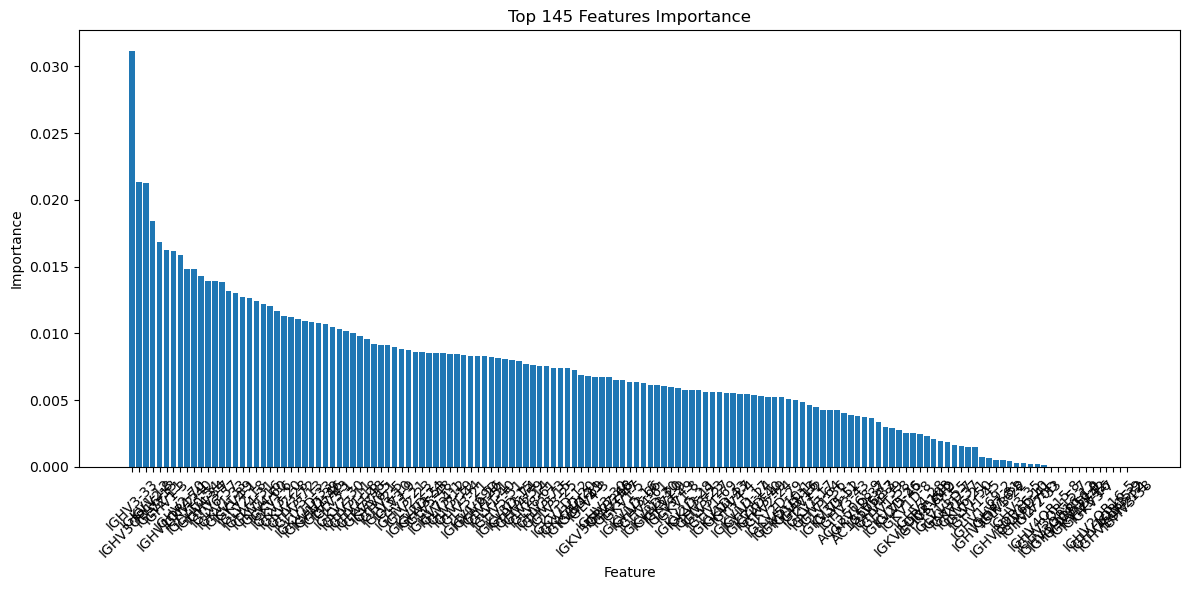

Last important feature:  133


In [16]:
df = pd.read_csv("../Datasets/Dataset18/data2.csv", index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

feature_names = X.columns

k_values = [145]

selected_features_dict = {}

for k in k_values:
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X, y)
    feature_importances = clf.feature_importances_
    selected_features = np.array(feature_names)[
        np.argsort(feature_importances)[::-1][:k]]

    selected_features_dict[k] = selected_features

    sorted_idx = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(12, 6))
    plt.title(f"Top {k} Features Importance")
    plt.bar(range(k), feature_importances[sorted_idx][:k], align="center")
    plt.xticks(range(k), np.array(feature_names)[sorted_idx][:k], rotation=45)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

    zero_importance_index = np.where(feature_importances == 0)[0]
    print("Last important feature: ", len(
        X.columns)-len(zero_importance_index))

### Feature Selection

In [17]:
df = pd.read_csv("../Datasets/Dataset18/data2.csv", index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

feature_counts = list(range(1, 133))

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

feature_importances = clf.feature_importances_

selected_features = X.columns[np.argsort(feature_importances)[::-1]]

datasets = {}
for count in feature_counts:
    datasets[count] = X[selected_features[:count]].copy()
    datasets[count]['Diagnosis'] = y

for count, dataset in datasets.items():
    dataset.to_csv(
        f'../Datasets/Dataset18/Feature_Select/dataset_{count}.csv', index=True)

## Model Building

### Check CV Score for Different Models

In [18]:
feature_counts = list(range(1, 133))

models = {
    "SVM(linear)": SVC(kernel='linear'),
    "SVM(poly)": SVC(kernel='poly'),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(),
    "ANN": MLPClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
}

results = pd.DataFrame(
    columns=["Model Name", "Feature Count", "CV Score (Mean +/- Std)"])

for count in tqdm(feature_counts, desc="Processing feature counts", unit=" feature counts", colour='green'):
    file_path = f"../Datasets/Dataset18/Feature_Select/dataset_{count}.csv"
    df = pd.read_csv(file_path, index_col=0)

    X = df.drop('Diagnosis', axis=1)
    y = df['Diagnosis']

    for model_name, model in models.items():
        cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
        if model_name == "ANN":
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=ConvergenceWarning)
                scores = cross_val_score(model, X, y, cv=cv)
        elif model_name == "Logistic Regression": 
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=ConvergenceWarning)
                scores = cross_val_score(model, X, y, cv=cv)
        else:
            scores = cross_val_score(model, X, y, cv=cv)
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        result = f"{mean_score:.4f} +/- {std_score:.4f}"
        new_data = pd.DataFrame({"Model Name": [model_name],
                                 "Feature Count": [count],
                                 "CV Score (Mean +/- Std)": [result]})
        results = pd.concat([results, new_data], ignore_index=True)
        # print(f"{model_name} with {count} features: {result}")

results.sort_values(by=["CV Score (Mean +/- Std)"],
                    ascending=False, inplace=True)
results.to_csv("../Datasets/Dataset18/Feature_Select/results.csv", index=False)

Processing feature counts:   0%|          | 0/132 [00:00<?, ? feature counts/s]

Processing feature counts: 100%|██████████| 132/132 [05:17<00:00,  2.41s/ feature counts]


In [19]:
df = pd.read_csv("../Datasets/Dataset18/Feature_Select/results.csv")
df.head(10)

,Model Name,Feature Count,CV Score (Mean +/- Std)
0,XGBoost,22,0.6897 +/- 0.0690
1,XGBoost,29,0.6828 +/- 0.0507
2,XGBoost,21,0.6759 +/- 0.0468
3,XGBoost,23,0.6759 +/- 0.0352
4,XGBoost,26,0.6759 +/- 0.0352
5,XGBoost,9,0.6759 +/- 0.0276
6,XGBoost,27,0.6690 +/- 0.0915
7,XGBoost,6,0.6690 +/- 0.0774
8,ANN,60,0.6690 +/- 0.0560
9,XGBoost,28,0.6690 +/- 0.0516


### Check Distributions

In [20]:
feature_count = 22

data = pd.read_csv(
    f'../Datasets/Dataset18/Feature_Select/dataset_{feature_count}.csv')

target_column = data.columns[feature_count + 1]

num_rows = math.ceil(feature_count / 4)
num_columns = 4

fig, axes = plt.subplots(num_rows, num_columns, figsize=(80, 140))

for i in range(min(feature_count, num_rows * num_columns)):
    row_index = i // num_columns
    col_index = i % num_columns

    sns.histplot(
        data=data, x=data.columns[i + 1], hue=target_column, kde=True, ax=axes[row_index, col_index])

    axes[row_index, col_index].set_title(
        f'Distribution of {data.columns[i + 1]}')

    axes[row_index, col_index].set_xlabel(data.columns[i + 1])

    axes[row_index, col_index].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

### Check Accuracy

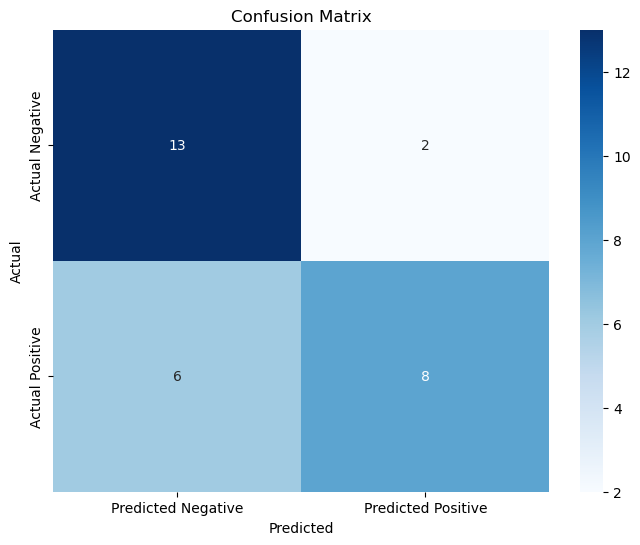

Accuracy: 0.72
Precision: 0.80
Recall (Sensitivity): 0.57
Specificity: 0.87
F1 Score: 0.67


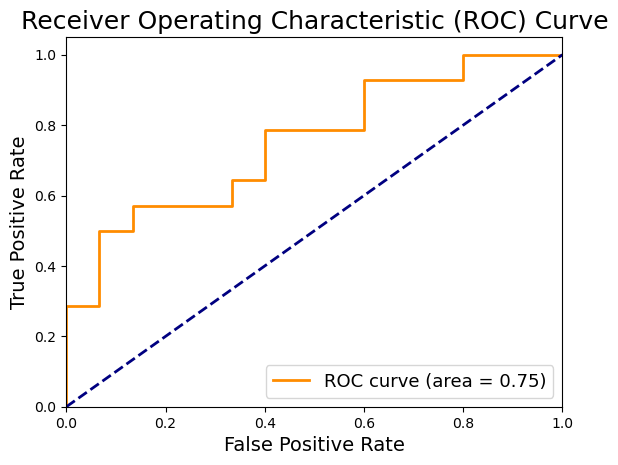

In [22]:
# feature_count = 43

df = pd.read_csv(
    f'../Datasets/Dataset18/Feature_Select/dataset_{feature_count}.csv', index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

clf = XGBClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

y_scores = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1 Score: {f1:.2f}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=18)
plt.legend(loc='lower right', fontsize=13)
plt.show()